# 목차(Table Of Contents)

Author : HYGN

0. [데이터소개](#introduction)
1. [데이터 불러오기](#paragraph1)
    1. [ID(차주정보)](#subparagraph1.1)
    2. [LN(대출정보)](#subparagraph1.2)
    3. [DLQ(연체정보)](#subparagraph1.3)
    4. [CD_OPN(카드개설정보)](#subparagraph1.4)
2. [Feature Engineering](#paragraph2)
    0. [Setup](#subparagraph2.0)
    1. [상환이력](#subparagraph2.1)
    2. [부채수준](#subparagraph2.2)
    3. [신용거래기간](#subparagraph2.3)
    4. [신용거래형태](#subparagraph2.4)

## 데이터 소개<a name="introduction"></a>

[CreDB 개인신용 교육용DB(light)](https://www.findatamall.or.kr/fsec/dataProd/generalDataProdDetail.do?cmnx=44&goods_id=dafb9c70-ba89-11ea-9d5e-2d76f6f19fec) : 금융데이터거래소에서 무료로 다운로드 가능합니다.

1) CreDB 소개
  * 본 데이터는 신용정보원에 집중되는 신용정보를 표본추출한 뒤 비식별 조치하여 **통계 작성 및 학술 연구 목적**으로 이용자에게 제공하는 서비스입니다.

2) CreDB 교육용DB 소개
  * 실제 개인이 아닌 가상의 차주에 대한 **재현데이터(synthetic data)**입니다.
  * 개인정보 유출 위험없이 교육 및 실습 목적으로 활용 가능합니다.

3) DB설명
  * 가상의 신용거래차주 2,000명에 대한 '16.12월 ~ '18.12월 (25개월)동안의 대출/연체/카드개설정보.
  * (파일) `ID.csv(차주정보), LN.csv(대출정보), DLQ.csv(연체정보), CDOPN.csv(카드개설정보)`

## Import libraries


In [1]:
import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
os.chdir("../../data")

In [4]:
import glob
path = "./credb/*.csv"
flist = glob.glob(path)
flist = sorted(flist)
flist

['./credb/1. CREDB_P1_ID.csv',
 './credb/2. CREDB_P1_LN.csv',
 './credb/3. CREDB_P1_DLQ.csv',
 './credb/4. CREDB_P1_CD_OPN.csv',
 './credb/credb.csv']

※ list에서 원본 list에 영향없이 정렬하고자 할 때, `sorted` 사용.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

%config InlineBackend.figure_format = 'retina' 
plt.style.use('ggplot')

## 데이터 불러오기 <a name="paragraph1"></a>

### a.ID(차주정보) <a name="subparagraph1.1"></a>
  - join_key(차주일련번호) : 다른 데이터와 결합 key
  - bth_yr(생년) : 19세 이하 / 20~79세 / 80세 이상
  - gender(성별) : 남성(1) / 여성(2)

In [6]:
id_dat = pd.read_csv(flist[0],sep="|")
id_dat.head()

,JOIN_KEY,BTH_YR,GENDER
0,X0010254691714933659,1990,1
1,X0013455316779233219,1954,2
2,X0019385710745765957,1977,1
3,X0019442830801994941,1992,1
4,X0032015350750301834,1968,1


In [7]:
id_dat['GENDER'] = id_dat['GENDER'].astype('object')

In [8]:
id_dat.columns = id_dat.columns.str.lower()

In [9]:
id_dat.isnull().sum()

join_key    0
bth_yr      0
gender      0
dtype: int64

In [10]:
id_dat['join_key'].nunique()

2000

: 총 2,000명의 차주데이터입니다.

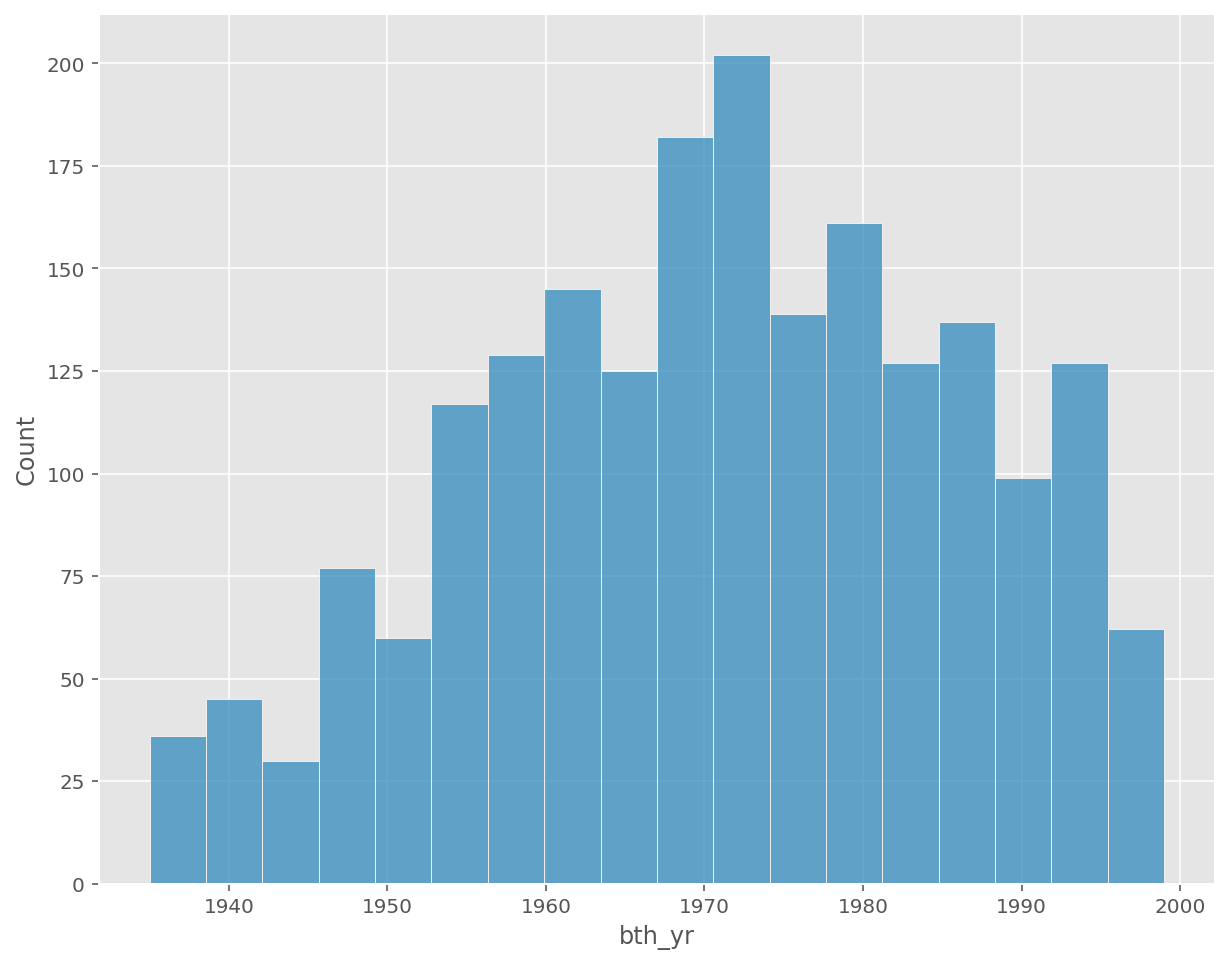

In [11]:
fig,ax = plt.subplots(figsize=(10,8))

sns.histplot(data=id_dat,x='bth_yr',stat='count')
plt.show()

In [12]:
id_dat['gender'].value_counts()

1    1094
2     906
Name: gender, dtype: int64

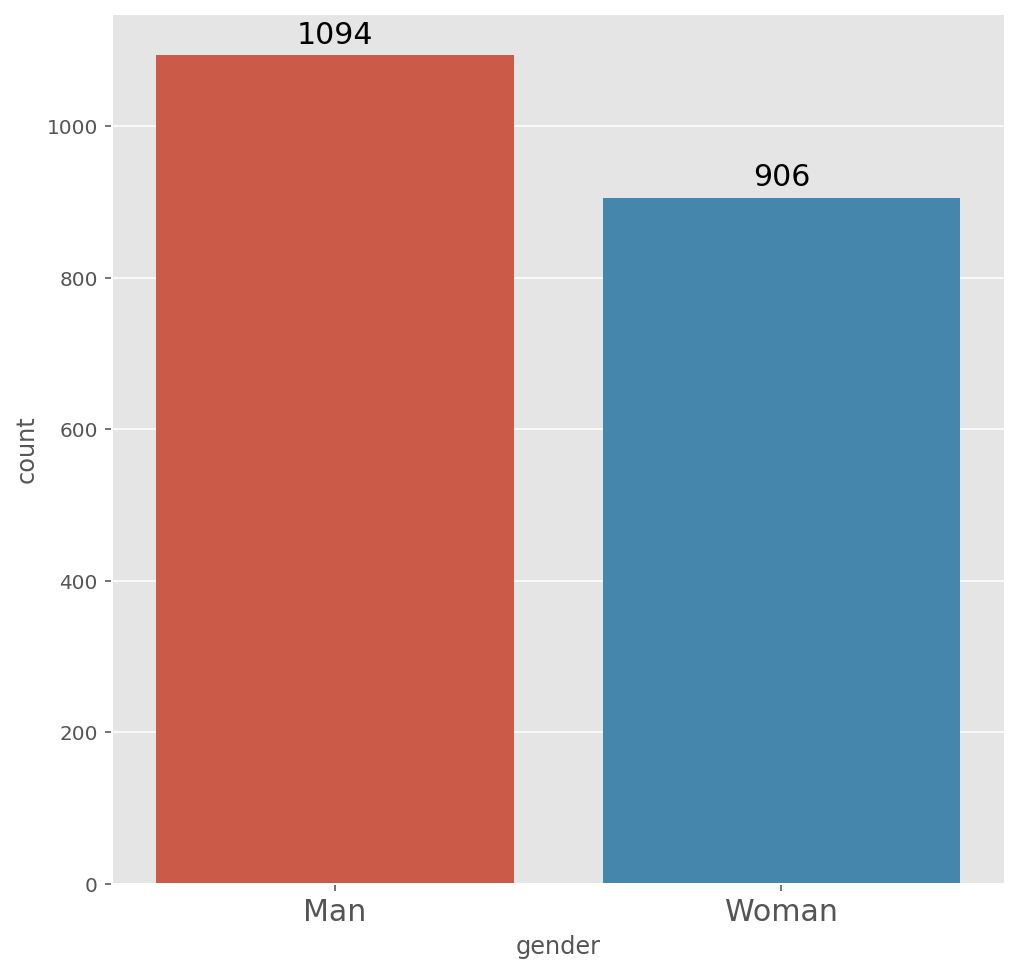

In [13]:
fig,ax = plt.subplots(figsize=(8,8))

sns.countplot(x='gender',data=id_dat)
ax.set_xticklabels(['Man','Woman'],{'fontsize':15})
for i in [1,2] : 
    height = id_dat['gender'].value_counts()[i]
    ax.annotate(height,xy=(i-1,height),xytext=(0, 3),
              textcoords="offset points",ha='center',va='bottom',fontsize=15)
plt.show()

### b.LN(대출정보)<a name="subparagraph1.2"></a>
  : 차주의 대출관련 정보를 대출기간 동안의 월말 snapshot 형태로 제공.
  
  : 예를 들어, 차주가 대출을 '17.1.15 ~ '17.5.15 동안 보유하고 있었다면 '17.1월말, 2월말, 3월말, 4월말 총 4개 시점의 정보를 제공.
 
 
  * ym(기준년월)
  * join_key(차주일련번호)
  * sctr_cd(업권코드) : 정보를 등록한 업권 구분코드(은행, 생보사, 손보사, 카드사, 캐피탈, 할부/리스/신기술사, 협동조합, 기타 등 8개)
  * com_key(기관일련번호) : 대출정보와 연체, 카드개설정보를 결합하기 위한 key
  * ln_cd_1(대출상품코드1) : 단기/장기 카드대출 등 대출상품구분
  * ln_cd_2(대출상품코드2) : 신용대출, 주택담보대출 등 대출상품구분
  * ln_ym(대출년월) : 대출정보가 등록된 년월
  * ln_amt(대출금액) : 기준월말 시점의 대출금액(단위: 천원) 

In [14]:
ln_dat = pd.read_csv(flist[1],sep="|")
ln_dat.head()

,YM,JOIN_KEY,SCTR_CD,COM_KEY,LN_CD_1,LN_CD_2,LN_YM,LN_AMT
0,201612,X0010254691714933659,1,X1363595463253465022,31,220,201610,19000
1,201612,X0010254691714933659,5,X2990775869667591539,41,0,201611,1000
2,201612,X0010254691714933659,1,X6048703495538110948,31,200,201612,10000
3,201612,X0010254691714933659,21,Y1605029911648266013,31,100,201604,5900
4,201701,X0010254691714933659,1,X1363595463253465022,31,220,201610,19000


In [15]:
ln_dat.columns = ln_dat.columns.str.lower()

In [16]:
ln_dat['ln_cd_2'] = ln_dat['ln_cd_2'].apply(lambda x : format(x,'003.0f'))

In [17]:
ln_dat['sctr_cd'] = ln_dat['sctr_cd'].astype('object') 
ln_dat['ln_cd_1'] = ln_dat['ln_cd_1'].astype('object') 
ln_dat['ln_cd_2'] = ln_dat['ln_cd_2'].astype('object') 

In [18]:
ln_dat['ln_cd'] = ln_dat['ln_cd_1'].astype('str') + ln_dat['ln_cd_2'].astype('str') 

In [19]:
ln_dat['join_key'].nunique()

1334

: 1,334명 차주의 대출정보가 기록되어 있습니다.

In [20]:
# matplotlib 한글 폰트 출력코드
# 출처 : 데이터공방( https://kiddwannabe.blog.me)

import matplotlib
from matplotlib import font_manager, rc
import platform

try : 
    if platform.system() == 'Windows':
    # 윈도우인 경우
        font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
    else:    
    # Mac 인 경우
        rc('font', family='AppleGothic')
except : 
    pass
matplotlib.rcParams['axes.unicode_minus'] = False

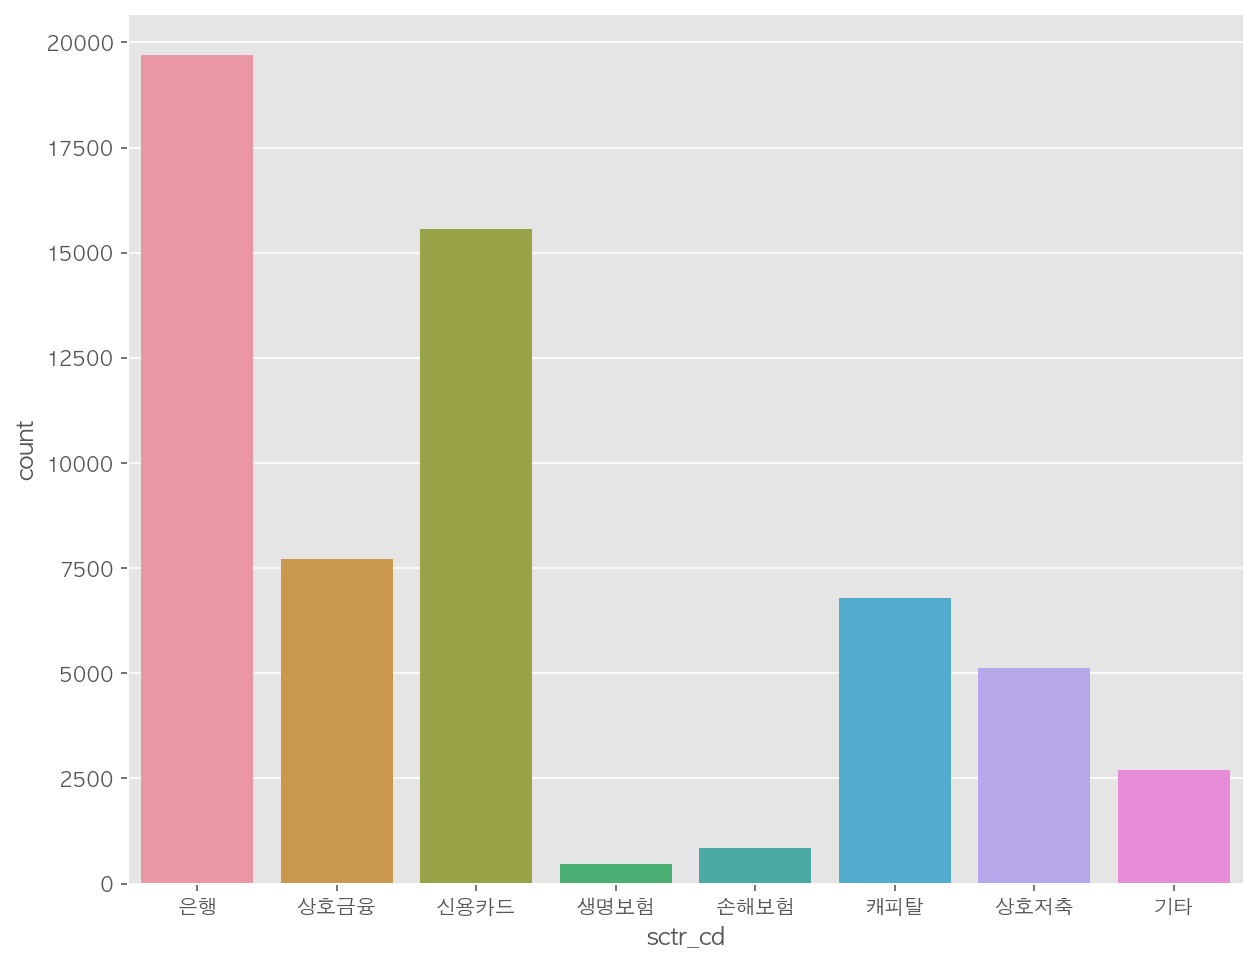

In [21]:
fig,ax = plt.subplots(1,figsize=(10,8))

sns.countplot(data=ln_dat,x='sctr_cd')
ax.set_xticklabels(['은행','상호금융','신용카드','생명보험','손해보험','캐피탈','상호저축','기타'])
plt.show()

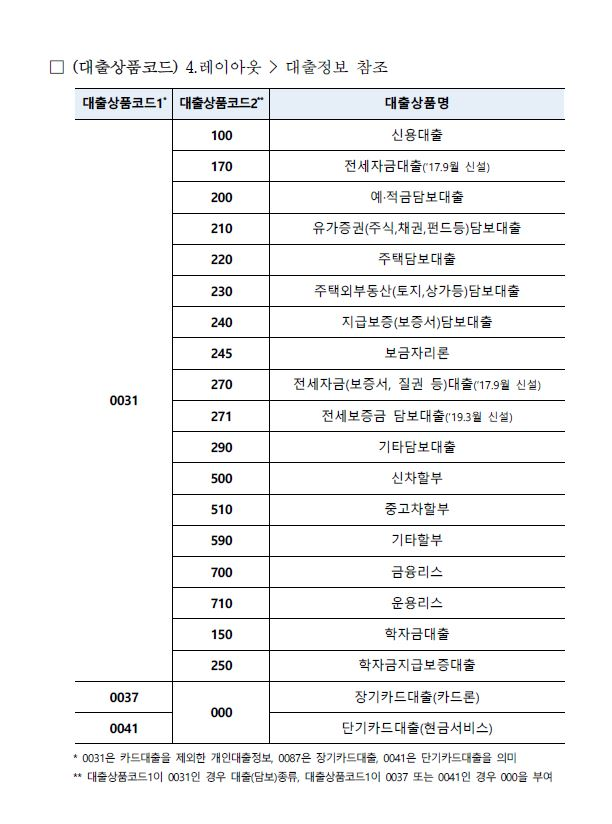

In [22]:
from IPython.display import Image
Image('./image/대출상품코드.JPG',width=500,height=700)

In [23]:
ln_dat['ln_cd_1'].value_counts()

31    42519
41     8389
37     8014
Name: ln_cd_1, dtype: int64

#### 방법 1. `pivot_table` 이용

In [24]:
ln_dat.pivot_table(index=['ln_cd_1','ln_cd_2'],values=['join_key','ln_amt'],aggfunc={'join_key' : 'count', 'ln_amt' : 'mean'})

join_key         ln_amt
ln_cd_1 ln_cd_2                         
31      100         20320   16657.503445
        150          1722    6761.387921
        170             3   11000.000000
        200          1608   14226.641791
        210           472   43211.440678
        220          7109  109922.140948
        230          1617  186772.356215
        240          2772   25157.297980
        245           514  123374.319066
        250           171   36470.467836
        270          1170   44143.786325
        271             8   42000.000000
        290           862   34487.981439
        500          2711   14893.714496
        510           923   19634.442037
        590           279   14853.046595
        700            62   18016.129032
        710           196   16022.959184
37      000          8014    5946.939107
41      000          8389    1422.623674

#### 방법 2. `groupby ` 이용.

In [25]:
ln_dat.groupby(by=['ln_cd_1','ln_cd_2'],as_index=False).agg({'join_key' : 'count', 'ln_amt' : 'mean'})

,ln_cd_1,ln_cd_2,join_key,ln_amt
0,31,100,20320,16657.503445
1,31,150,1722,6761.387921
2,31,170,3,11000.000000
3,31,200,1608,14226.641791
4,31,210,472,43211.440678
5,31,220,7109,109922.140948
6,31,230,1617,186772.356215
7,31,240,2772,25157.297980
8,31,245,514,123374.319066
9,31,250,171,36470.467836


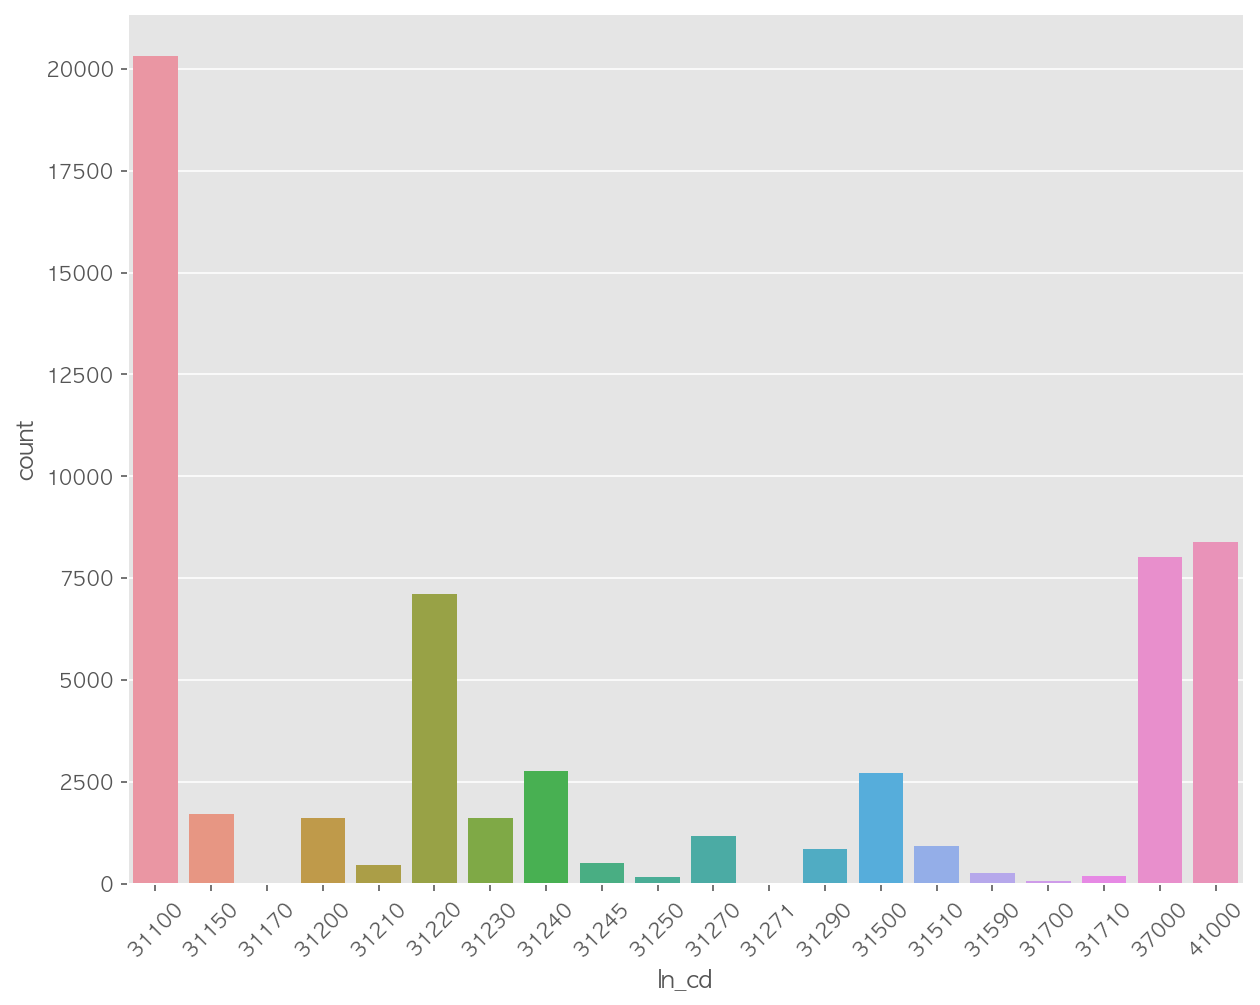

In [26]:
fig,ax = plt.subplots(figsize=(10,8))

sns.countplot(data=ln_dat.sort_values('ln_cd'),x='ln_cd')
plt.xticks(rotation=45)
plt.show()

: 신용대출, 단기카드대출, 장기카드대출, 주택담보대출 순으로 대출 건수가 많음.

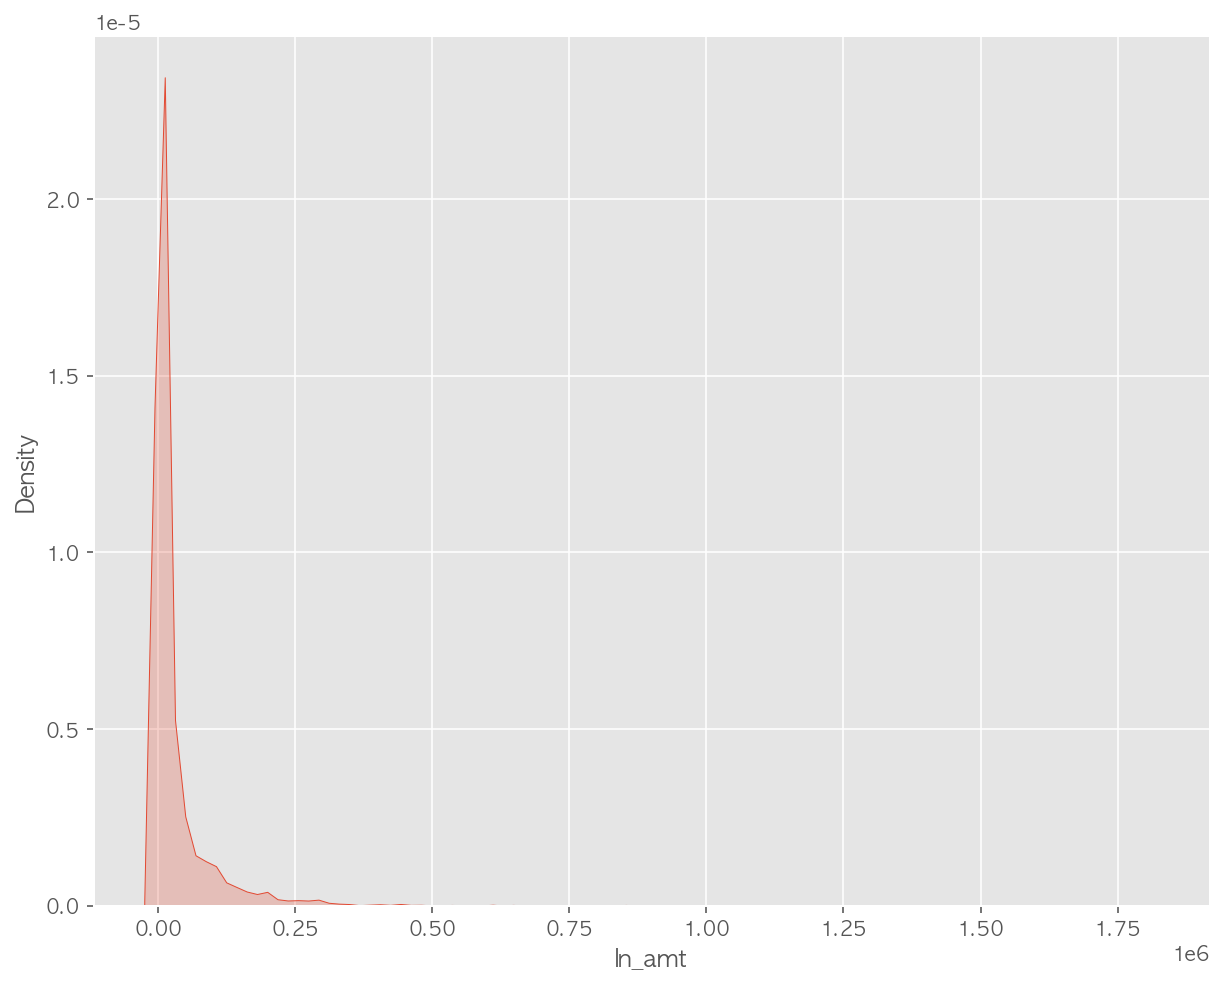

In [27]:
fig,ax = plt.subplots(figsize=(10,8))

sns.kdeplot(data=ln_dat,x='ln_amt',ax=ax,shade=True,gridsize=100)
plt.show()

In [28]:
ln_dat.pivot_table(index=['ln_cd_1','ln_cd_2'],values=['ln_amt'],aggfunc={'ln_amt' : ['min','mean','max']})

ln_amt                        
                       max           mean      min
ln_cd_1 ln_cd_2                                   
31      100       280000.0   16657.503445     10.0
        150        42000.0    6761.387921     20.0
        170        11000.0   11000.000000  11000.0
        200       150000.0   14226.641791     40.0
        210       150000.0   43211.440678   4000.0
        220      1200000.0  109922.140948   2100.0
        230      1800000.0  186772.356215   3300.0
        240       230000.0   25157.297980    500.0
        245       310000.0  123374.319066   3800.0
        250       180000.0   36470.467836    510.0
        270       260000.0   44143.786325    190.0
        271        42000.0   42000.000000  42000.0
        290       270000.0   34487.981439    370.0
        500       130000.0   14893.714496     50.0
        510       120000.0   19634.442037    210.0
        590       120000.0   14853.046595    100.0
        700        71000.0   18016.129032   2200.0
        710        72000.0   16022.959184    940.0
37      000        26000.0    5946.939107    100.0
41      000        15000.0    1422.623674     10.0

: 대출종류에 따라 규모의 차이가 큼.

### c.DLQ(연체정보)<a name="subparagraph1.3"></a>

In [29]:
dlq_dat = pd.read_csv(flist[2],sep="|")
dlq_dat.head()

,YM,JOIN_KEY,SCTR_CD,COM_KEY,DLQ_TYPE,DLQ_CD_1,DLQ_CD_2,DLQ_YM,DLQ_AMT
0,201801,X0010254691714933659,21,Y1605029911648266013,1,101,0,201801,5700
1,201802,X0010254691714933659,21,Y1605029911648266013,1,101,0,201801,5700
2,201612,X0214807498644962070,5,Y4755574378503849999,1,104,7,201611,900
3,201612,X0214807498644962070,98,Y9036878020951295900,1,101,0,201404,10000
4,201701,X0214807498644962070,5,Y4755574378503849999,1,104,7,201611,900


In [30]:
dlq_dat.columns = dlq_dat.columns.str.lower()

In [31]:
dlq_dat['sctr_cd'] = dlq_dat['sctr_cd'].astype('object') 
dlq_dat['com_key'] = dlq_dat['com_key'].astype('object') 

dlq_dat['dlq_type'] = dlq_dat['dlq_type'].astype('object') 
dlq_dat['dlq_cd_1'] = dlq_dat['dlq_cd_1'].astype('object') 
dlq_dat['dlq_cd_2'] = dlq_dat['dlq_cd_2'].astype('object') 

In [32]:
dlq_dat['join_key'].nunique()

400

: 400명 차주의 연체정보가 있음.

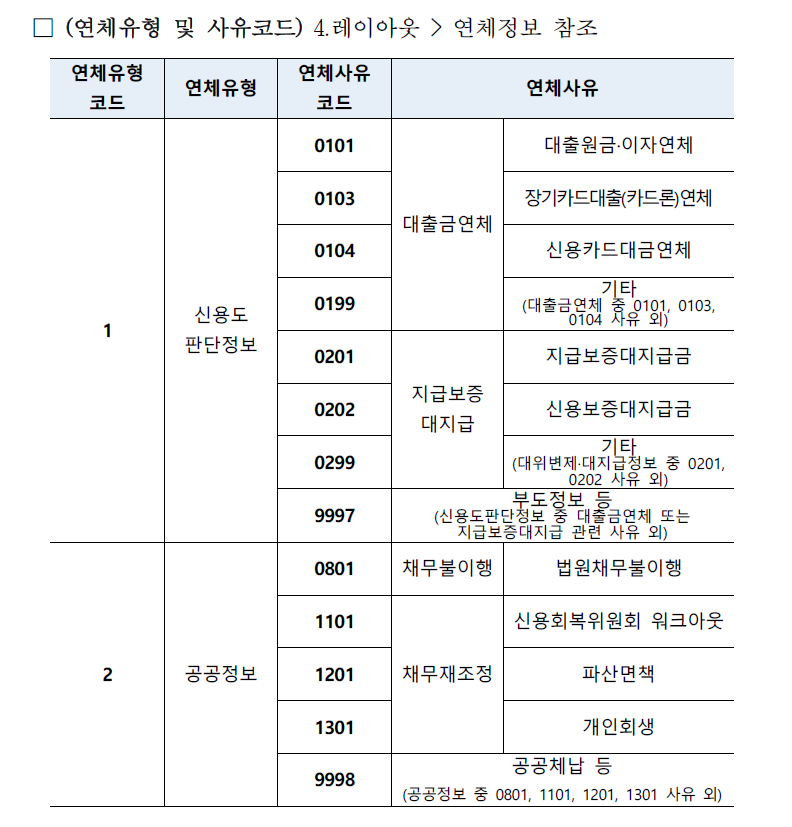

In [33]:
Image('./image/연체유형및사유.PNG',width=500,height=500)

※ 제공된 자료는 `dlq_type = 1` 인 경우만 있음.

In [34]:
dlq_dat['dlq_type'].unique()

array([1], dtype=object)

In [35]:
dlq_dat['dlq_cd_1'] = dlq_dat['dlq_cd_1'].apply(lambda x : format(x,'0004.0f'))

In [36]:
sorted(dlq_dat['dlq_cd_1'].unique())

['0101', '0103', '0104', '0199', '0201', '0202', '0299', '9997']

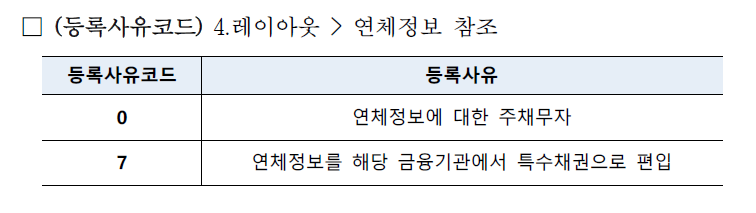

In [37]:
Image('./image/등록사유코드.PNG',width=500,height=150)

In [38]:
dlq_dat['dlq_cd_2'].unique()

array([0, 7], dtype=object)

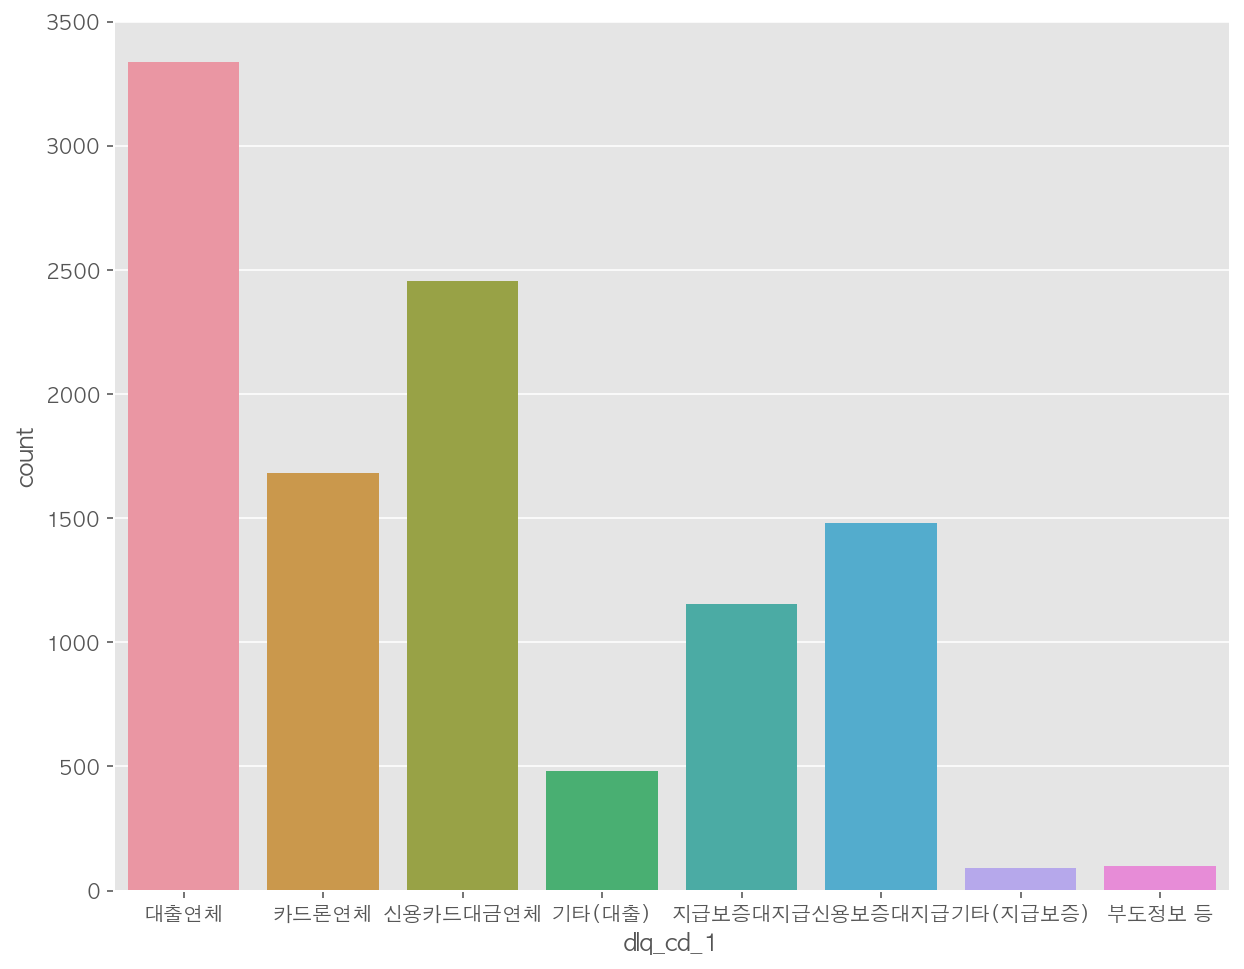

In [39]:
fig,ax = plt.subplots(figsize=(10,8))

sns.countplot(data=dlq_dat.sort_values('dlq_cd_1'),x='dlq_cd_1')
ax.set_xticklabels(['대출연체','카드론연체','신용카드대금연체','기타(대출)','지급보증대지급','신용보증대지급','기타(지급보증)','부도정보 등'])
plt.show()

In [40]:
dlq_dat.pivot_table(index='dlq_cd_1',values='dlq_amt',aggfunc={'dlq_amt' : ['min','mean','max']})

,max,mean,min
dlq_cd_1,,,
0101,590000.0,28798.496105,70.0
0103,29000.0,6496.198691,170.0
0104,24000.0,3405.543788,60.0
0199,1500000.0,94891.614907,70.0
0201,21000.0,2736.865801,10.0
0202,480000.0,34612.948718,100.0
0299,7100.0,4310.000000,1800.0
9997,95000.0,37250.000000,3000.0


### d.CD_OPN(카드개설정보)<a name="subparagraph1.4"></a>

In [41]:
cd_dat = pd.read_csv(flist[3],sep="|")
cd_dat.head()

,YM,JOIN_KEY,COM_KEY,CD_OPN_CD_1,CD_OPN_CD_2,CD_OPN_YM
0,201612,X0010254691714933659,X0739620684726734804,81,1,201312
1,201612,X0010254691714933659,X2414244151238889690,81,1,200006
2,201612,X0010254691714933659,X2990775869667591539,81,1,201107
3,201612,X0010254691714933659,Y5029072213910072970,81,1,201511
4,201701,X0010254691714933659,X0739620684726734804,81,1,201312


In [42]:
cd_dat.columns = cd_dat.columns.str.lower()

In [43]:
cd_dat['ym'] = pd.to_datetime(cd_dat['ym'],format='%Y%m')
cd_dat['cd_opn_ym'] = pd.to_datetime(cd_dat['cd_opn_ym'],format='%Y%m')

## 2.Feature Engineering<a name="paragraph2"></a>

* 기준시점은 17년 12월로  설정.

* '불량'은 '향후 1년 이내 2달 이상의 연체' 발생한 경우.



#### 0.Setup<a name="subparagraph2.0"></a>

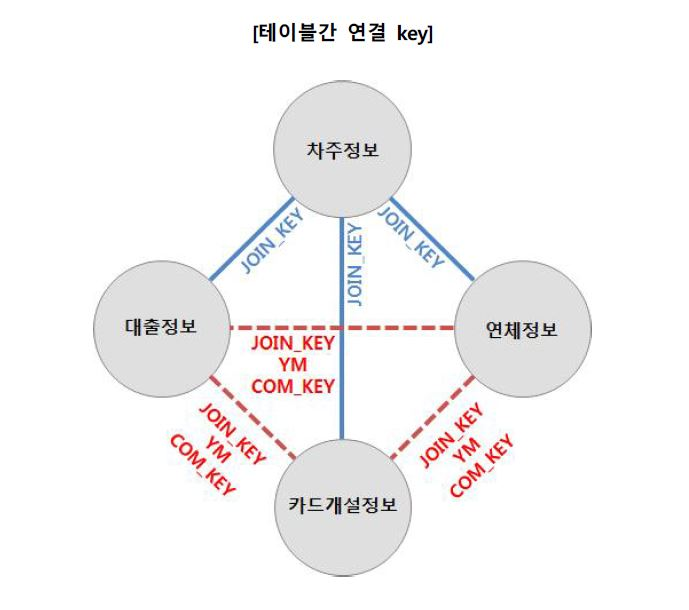

In [44]:
Image("./image/테이블간연결.JPG",width=500,height=450)

In [45]:
key1 = ['join_key']
key2 = ['join_key','ym','com_key']

In [46]:
loan = ln_dat.merge(id_dat,how='left', on = key1)
loan.head()

,ym,join_key,sctr_cd,com_key,ln_cd_1,ln_cd_2,ln_ym,ln_amt,ln_cd,bth_yr,gender
0,201612,X0010254691714933659,1,X1363595463253465022,31,220,201610,19000,31220,1990,1
1,201612,X0010254691714933659,5,X2990775869667591539,41,000,201611,1000,41000,1990,1
2,201612,X0010254691714933659,1,X6048703495538110948,31,200,201612,10000,31200,1990,1
3,201612,X0010254691714933659,21,Y1605029911648266013,31,100,201604,5900,31100,1990,1
4,201701,X0010254691714933659,1,X1363595463253465022,31,220,201610,19000,31220,1990,1


In [47]:
loan['join_key'].nunique()

1334

In [48]:
loan = loan.drop(['ln_cd_1','ln_cd_2'],axis=1)

In [49]:
loan = loan.sort_values(['ym','join_key','ln_ym'])

In [50]:
loan.isnull().sum()

ym          0
join_key    0
sctr_cd     0
com_key     0
ln_ym       0
ln_amt      0
ln_cd       0
bth_yr      0
gender      0
dtype: int64

In [51]:
loan['year'] = pd.to_datetime(loan['ym'],format='%Y%m').dt.year
loan['ln_year'] = pd.to_datetime(loan['ln_ym'],format='%Y%m').dt.year

In [52]:
dlq = id_dat[key1].merge(dlq_dat,on=key1,how='left')
dlq.head()

,join_key,ym,sctr_cd,com_key,dlq_type,dlq_cd_1,dlq_cd_2,dlq_ym,dlq_amt
0,X0010254691714933659,201801.0,21,Y1605029911648266013,1,0101,0,201801.0,5700.0
1,X0010254691714933659,201802.0,21,Y1605029911648266013,1,0101,0,201801.0,5700.0
2,X0013455316779233219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,X0019385710745765957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,X0019442830801994941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
dlq = dlq.drop(['dlq_type'],axis=1)

In [54]:
dlq = dlq.sort_values(['ym','join_key','dlq_ym'])

In [55]:
dlq.isnull().sum()

join_key       0
ym          1600
sctr_cd     1600
com_key     1600
dlq_cd_1    1600
dlq_cd_2    1600
dlq_ym      1600
dlq_amt     1600
dtype: int64

In [56]:
dlq = dlq.dropna(axis=0, how='any')

In [57]:
dlq['join_key'].nunique()

400

In [58]:
(loan.merge(dlq,on=key2,how='right'))

,ym,join_key,sctr_cd_x,com_key,ln_ym,ln_amt,ln_cd,bth_yr,gender,year,ln_year,sctr_cd_y,dlq_cd_1,dlq_cd_2,dlq_ym,dlq_amt
0,201612,X0214807498644962070,NaN,Y9036878020951295900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98,0101,0,201404.0,10000.0
1,201612,X0214807498644962070,NaN,Y4755574378503849999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0104,7,201611.0,900.0
2,201612,X0301386901660578111,NaN,Y6347148541722377879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0101,7,201102.0,8000.0
3,201612,X0342060941186493169,NaN,X0945035270612736741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9997,0,200811.0,95000.0
4,201612,X0392110483605601454,NaN,X4067398789839021726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0104,7,201508.0,9500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12185,201812,Y9036303097000880027,NaN,X8773646356761399277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98,0202,0,201809.0,12000.0
12186,201812,Y9110632481067346149,NaN,Y5299577101663249765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0101,7,201408.0,2100.0
12187,201812,Y9125059031177509047,NaN,X7867720133176175984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0103,7,201309.0,2200.0
12188,201812,Y9125059031177509047,NaN,X3239332823850850343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0103,7,201601.0,5200.0


: 대출 기록은 없고 연체가 있는 자료 존재함. 

In [59]:
standard_year = 201712

In [60]:
df_loan = loan.copy()
df_dlq = dlq.copy()

In [61]:
df_loan = df_loan[(df_loan['ym']==201712)]

In [62]:
df_ln = df_loan[(df_loan['sctr_cd']==1)&(df_loan['ym']==201712)]
df1 = df_ln.groupby(['join_key','gender'],as_index=False).agg({'ln_amt':'sum','bth_yr':'mean'})
df1.head()

,join_key,gender,ln_amt,bth_yr
0,X0010254691714933659,1,10000,1990
1,X0019385710745765957,1,43000,1977
2,X0032015350750301834,1,114200,1968
3,X0080319379158089172,1,48300,1985
4,X0214807498644962070,1,301400,1973


In [63]:
df2 = df_dlq[(df_dlq['ym']==201712)].groupby(['join_key'],as_index=False).agg({'dlq_amt':'sum'})
df2.head()

,join_key,dlq_amt
0,X0214807498644962070,22900.0
1,X0342060941186493169,95000.0
2,X0392110483605601454,13800.0
3,X0455965488226319910,900.0
4,X0474444465014724107,10400.0


In [64]:
df = df1.merge(df2,on='join_key',how='left')
df.loc[df['dlq_amt'].isnull()==True,'dlq_amt'] = 0
df.head()

,join_key,gender,ln_amt,bth_yr,dlq_amt
0,X0010254691714933659,1,10000,1990,0.0
1,X0019385710745765957,1,43000,1977,0.0
2,X0032015350750301834,1,114200,1968,0.0
3,X0080319379158089172,1,48300,1985,0.0
4,X0214807498644962070,1,301400,1973,22900.0


#### 1.상환이력<a name="subparagraph2.1"></a>

: 연체건수, 연체일수, 연체상환 후 경과일수, 연체금액 등

In [65]:
import datetime as dt

In [66]:
df_dlq['ym'] = pd.to_datetime(df_dlq['ym'],format='%Y%m')
df_dlq['dlq_ym'] = pd.to_datetime(df_dlq['dlq_ym'],format='%Y%m')

In [67]:
df_dlq['year'] = pd.to_datetime(df_dlq['ym'],format='%Y%m').dt.year
df_dlq['dlq_year'] = pd.to_datetime(df_dlq['dlq_ym'],format='%Y%m').dt.year

df_dlq['month'] = pd.to_datetime(df_dlq['ym'],format='%Y%m').dt.month
df_dlq['dlq_month'] = pd.to_datetime(df_dlq['dlq_ym'],format='%Y%m').dt.month

In [68]:
dlq2017 = df_dlq[(df_dlq['ym'] <= '2017-12-01')]
dlq2018 = df_dlq[(df_dlq['dlq_ym'] >= '2017-12-01')&(df_dlq['year'] == 2018)]

print(dlq2017.shape,dlq2018.shape)

(5787, 12) (1082, 12)


In [69]:
dlq2017 = dlq2017.reset_index().drop(['index'],axis=1)
dlq2018 = dlq2018.reset_index().drop(['index'],axis=1)

In [70]:
dlq2017.head()

,join_key,ym,sctr_cd,com_key,dlq_cd_1,dlq_cd_2,dlq_ym,dlq_amt,year,dlq_year,month,dlq_month
0,X0214807498644962070,2016-12-01,98,Y9036878020951295900,0101,0,2014-04-01,10000.0,2016,2014,12,4
1,X0214807498644962070,2016-12-01,5,Y4755574378503849999,0104,7,2016-11-01,900.0,2016,2016,12,11
2,X0301386901660578111,2016-12-01,1,Y6347148541722377879,0101,7,2011-02-01,8000.0,2016,2011,12,2
3,X0342060941186493169,2016-12-01,1,X0945035270612736741,9997,0,2008-11-01,95000.0,2016,2008,12,11
4,X0392110483605601454,2016-12-01,1,X4067398789839021726,0104,7,2015-08-01,9500.0,2016,2015,12,8


In [71]:
%%time
for i,row in df.iterrows(): 
    tmp = (dlq2017[dlq2017['join_key'] ==row['join_key']]).groupby(['com_key','dlq_ym','sctr_cd','dlq_cd_1','dlq_amt'],as_index=False).agg({'ym':'max'})
    if(len(tmp)!=0):
        df.loc[i,'pre_dlq_days'] = np.mean(12*(pd.to_datetime(standard_year,format='%Y%m').year - tmp['dlq_ym'].dt.year)+ (pd.to_datetime(standard_year,format='%Y%m').month - tmp['dlq_ym'].dt.month))
        df.loc[i,'dlq'] = 1
        df.loc[i,'num_overdue'] = tmp[tmp['ym'] == '2017-12-01']['com_key'].nunique() #기준시점 기준 보유 연체건수
    else : 
        df.loc[i,'pre_dlq_days'] = 0
        df.loc[i,'dlq'] = 0
        df.loc[i,'num_overdue'] = 0 

CPU times: user 3.77 s, sys: 31.9 ms, total: 3.8 s
Wall time: 3.82 s


In [72]:
%%time
for i,row in df.iterrows(): 
    tmp = (dlq2018[dlq2018['join_key'] ==row['join_key']]).groupby(['com_key','dlq_ym','sctr_cd','dlq_cd_1','dlq_amt'],as_index=False).agg({'ym':'max'})
    if(len(tmp)!=0):
        df.loc[i,'dlq_count_2018'] = np.mean(12*(tmp['ym'].dt.year - tmp['dlq_ym'].dt.year)+ (tmp['ym'].dt.month - tmp['dlq_ym'].dt.month))
    else : 
        df.loc[i,'dlq_count_2018'] = 0

CPU times: user 2.9 s, sys: 19.4 ms, total: 2.92 s
Wall time: 2.92 s


In [73]:
month_of_overdue = 2

In [74]:
df['ex_long'] = df['pre_dlq_days'].apply(lambda x : np.where(x>=month_of_overdue,1,0))
df['long'] = df['dlq_count_2018'].apply(lambda x : np.where(x>=month_of_overdue,1,0))

#### 2.부채수준 <a name="subparagraph2.2"></a>

: 총 대출건수, 대출기관 수, 대출규모 대비 상환율 등.


In [75]:
%%time
for i,row in df.iterrows(): 
    tmp1 = (dlq2017[dlq2017['join_key'] ==row['join_key']]).groupby(['com_key','dlq_ym','sctr_cd','dlq_cd_1'],as_index=False).agg({'ym':'max'})
    if(len(tmp1)!=0):
        df.loc[i,'num_loan'] = tmp1['com_key'].nunique()
    else : 
        df.loc[i,'num_loan'] = 0 
    del tmp1

CPU times: user 3.09 s, sys: 18.8 ms, total: 3.11 s
Wall time: 3.12 s


In [76]:
df['repay_rate'] = (df['ln_amt']-df['dlq_amt'])/df['ln_amt']

#### 3.신용거래기간<a name="subparagraph2.3"></a>

: 신용거래 3년 이상, 7년 이상

In [77]:
df_loan.groupby('join_key',as_index=False).agg({'ln_ym':'min','ln_year':'min'})

,join_key,ln_ym,ln_year
0,X0010254691714933659,201604,2016
1,X0013455316779233219,201712,2017
2,X0019385710745765957,200112,2001
3,X0019442830801994941,201712,2017
4,X0032015350750301834,201507,2015
...,...,...,...
1083,Y9162920100890872630,201506,2015
1084,Y9164594422746599633,200906,2009
1085,Y9180567206231416881,201601,2016
1086,Y9181513434793472471,201509,2015


In [78]:
%%time
for i,row in df.iterrows():
    tmp = df_loan[df_loan['join_key']==row['join_key']].groupby(['join_key'],as_index=False).agg({'ln_ym':'min','ln_year':'min'})
    df.loc[i,'over_3y'] = np.where(pd.to_datetime(standard_year,format='%Y%m').year - tmp['ln_year']>3,1,0)

CPU times: user 2.21 s, sys: 31.1 ms, total: 2.24 s
Wall time: 2.23 s


#### 4.신용거래형태<a name="subparagraph2.4"></a>

: 보유대출업권, 보유대출 속성, 대출개설 빈도 등

In [79]:
%%time
for i,row in df.iterrows():
    tmp = df_loan[df_loan['join_key']==row['join_key']].groupby(['com_key','ln_ym','sctr_cd','ln_cd'],as_index=False).agg({'ym':'max'})
    df.loc[i,'cnt_1st'] = len(tmp[tmp['sctr_cd']==1])
    df.loc[i,'cnt_2nd'] = len(tmp[(tmp['sctr_cd']==3)|(tmp['sctr_cd']==21)])
    df.loc[i,'cnt_card'] = len(tmp[tmp['sctr_cd']==5])
    df.loc[i,'cnt_insurance'] = len(tmp[(tmp['sctr_cd']==6)|(tmp['sctr_cd']==8)])

CPU times: user 4.4 s, sys: 25.4 ms, total: 4.42 s
Wall time: 4.43 s


In [80]:
df['age'] = pd.to_datetime(standard_year,format='%Y%m').year - df['bth_yr']
df = df.drop(['bth_yr','pre_dlq_days','dlq_count_2018','dlq'],axis=1)

In [81]:
df = df[df['repay_rate']>=0]

In [82]:
df.describe()

,gender,ln_amt,dlq_amt,num_overdue,ex_long,long,num_loan,repay_rate,over_3y,cnt_1st,cnt_2nd,cnt_card,cnt_insurance,age
count,494.000000,4.940000e+02,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000
mean,1.378543,8.216249e+04,790.141700,0.105263,0.089069,0.054656,0.178138,0.976874,0.412955,1.506073,0.198381,0.419028,0.046559,45.483806
std,0.485515,1.308206e+05,5650.224195,0.460457,0.285132,0.227538,0.671536,0.111693,0.492864,0.822456,0.588184,0.984938,0.220313,12.342260
min,1.000000,1.000000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.013333,0.000000,1.000000,0.000000,0.000000,0.000000,18.000000
25%,1.000000,1.012500e+04,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,36.000000
50%,1.000000,4.000000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,44.000000
75%,2.000000,1.000000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,53.000000
max,2.000000,1.800000e+06,83600.000000,4.000000,1.000000,1.000000,5.000000,1.000000,1.000000,6.000000,5.000000,6.000000,2.000000,82.000000


In [83]:
df.to_csv("./credb/credb.csv",index=False)